In [1]:
import seaborn as sns
import metapack as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 

%matplotlib inline
sns.set_context('notebook')
mp.jupyter.init()


In [2]:
pkg = mp.jupyter.open_package()
#pkg = mp.jupyter.open_source_package()
pkg

# Downtown San Diego Homeless Sleepers
`sandiegodata.org-dowtown_homeless-7` Last Update: 2019-10-02T16:56:34

_Five years of monthly geographic positions for homeless sleepers in Downtown San Diego_


This dataset provides geographic locations for homeless sleepers in Downtown San Diego, as counted by enumerators from the Downtown San Diego Partnership. These counts have been done monthly since 2012, and this dataset provides counts since 2014. 

<center><a
href="https://data.sandiegodata.org/wp-content/uploads/sites/18/2019/10/Homeless
-Sleepers.png"><img
src="https://data.sandiegodata.org/wp-content/uploads/sites/18/2019/10/Homeless-
Sleepers.png" width="400px"></a></center>


The count is done on paper maps with handwritten count marks. The San Diego
Regional Data Library's [Downton Homelessness
project](http://downtown-homelessness.sandiegodata.org/) converted these
scanned count maps using a [web based image annotation
tool](http://www.robots.ox.ac.uk/~vgg/software/via/).

## Base and Imputed Datasets

This distribution has two version of the homeless counts, the base set,
``homeless_counts``, which has three months of missing data, and the imputed
dataset, ``imputed_counts`` in which these three missing months, 2014-08,
2014-09, and 2015-06 are probabilistically re-created.

The Imputation process uses the total count for the month, from the
``monthly_totals`` dataset, as the number of sleepers that the imputed month
will have. Then, the imputation process collects at least 1,000 records with
dates near the missing month into a sample set, calculating the portion of
records that are in each census block. Then the algorithm randomly selects that
number of records for each census block, and adjusts random blocks so the total
of the whole set of selected records is equal to the official count for the
month.

The result is an imputed month that has the same number of records as the
official count for the month and as the same portion of sleepers in each census
block as in adjacent months.

## Caveats

Because this data is extracted, manually, from manually recorded maps, there
are a lot of quality issues. 

### Missing Months

Because of conversion errors and some complications with the source maps, there
are several months of data that are excluded from this dataset

* **August 2014**. In the original datasets, August 2014 was a duplicate of September 2014. 
* **September 2014**. Comfusion related to the duplication of September and August resulted in September being incompletely processed. 
* **June 2015**. All of the map images for this month were blank. An alternate source PDF exists that is not blank, but this file was not used.     

These months are re-created, probabilistically, in the ``imputed_counts``
dataset.

### Not Using Ocupancy Multipliers

Since about 2017, HUD has instructed point-in-time homeless counts to multiply
the counts of sleepers in structures and vehicles by factors to account for
people who may be obsured and not directly countable. From April 2017 on,
Downtown San Diego Partnership has been using these factors.

However, this dataset does not use the occupancy factors, to allow analysts to
apply these factors consistently across all months of data. As a result, the
counts from this dataset diverge from the official counts after March 2017.

### Other Issues 

* The ``total_count`` often does not match the sum of counts on the map. These sums were made by hand, by the enumerator who made the counts, so there are occasional arithmetic errors.  
* There are many instances of missing values for ``rain`` or ``temp``
* Some dates include the day of the month, but many don't These dates have a day of month of 1.
* Date day of month is generally unreliable. Only the year and month are reliable, except for files noted above. 
* The ``neighborhood`` value is based on the map names, so in some months
  the East Village neighborhood is separated into ``east_village`` and ``east_village_south``

### Compar

In [3]:
display(pkg.resource('homeless_counts'))
hc = pkg.resource('homeless_counts').geoframe()
hc['date'] = pd.to_datetime(hc.date)

hc['keep'] = True
hc.loc[(hc.date.dt.month == 9) & (hc.date.dt.year == 2014),'keep'] = False
hc.loc[(hc.date.dt.month == 8) & (hc.date.dt.year == 2014),'keep'] = False
hc.loc[(hc.date.dt.month == 6) & (hc.date.dt.year == 2015),'keep'] = False
hc = hc[hc.keep]

hc.head()

Header,Type,Description
neighborhood,string,"Neighborhood, from the label on the source map"
date,date,"Date of the observation. Many dates have no know day of month; for these dates, the day of month is set to 1"
type,string,"Type of sleeper: individual, vehicle or structure"
temp,float,"Temperature, if it was written on the source map"
rain,string,"Rain or clear, if it was written on the source map"
geoid,string,"Census geoid for the 2010 Census block the observation is in, in ACS format"
x,number,"X geographic position, in California State Plane 6, EPSG:2230"
y,number,"Y geographic position, in California State Plane 6, EPSG:2230"
geometry,string,"Geographic position of observation, in Lat/Lon, EPSG:4326"


,neighborhood,date,type,temp,rain,geoid,x,y,geometry,keep
0,east_village,2017-08-31,individual,,,10100US060730054004017,6.282685e+06,1.839585e+06,"POLYGON ((-117.157385 32.710435, -117.157386 3...",True
1,east_village,2017-08-31,individual,,,10100US060730054004017,6.282685e+06,1.839585e+06,"POLYGON ((-117.157385 32.710435, -117.157386 3...",True
2,east_village,2015-02-26,individual,,clear,10100US060730054004017,6.282705e+06,1.839576e+06,"POLYGON ((-117.157385 32.710435, -117.157386 3...",True
3,east_village,2017-10-23,individual,66.0,clear,10100US060730054004017,6.282745e+06,1.839588e+06,"POLYGON ((-117.157385 32.710435, -117.157386 3...",True
4,east_village,2015-03-26,individual,,clear,10100US060730054004017,6.282740e+06,1.839639e+06,"POLYGON ((-117.157385 32.710435, -117.157386 3...",True


Text(0.5, 1.0, 'Sleeper Count Per Month For Offical Data vs This Dataset')

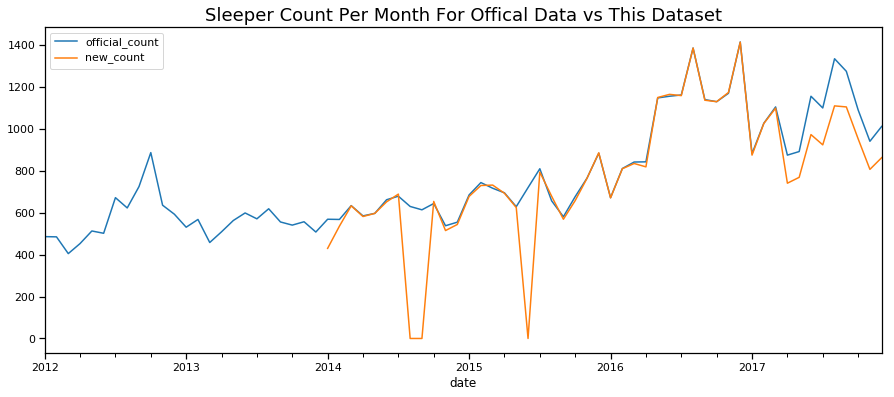

In [4]:
hc['new_count'] = 1
t = hc.set_index('date').groupby(pd.Grouper(freq="MS")).new_count.count().to_frame()
mt = pkg.resource('monthly_totals').dataframe().set_index('date').groupby(pd.Grouper(freq="MS")).sum().rename(columns={'count':'official_count'})

j = mt.join(t)
ax = j.plot(figsize=(15,6))
ax.set_title('Sleeper Count Per Month For Offical Data vs This Dataset', fontsize=18)


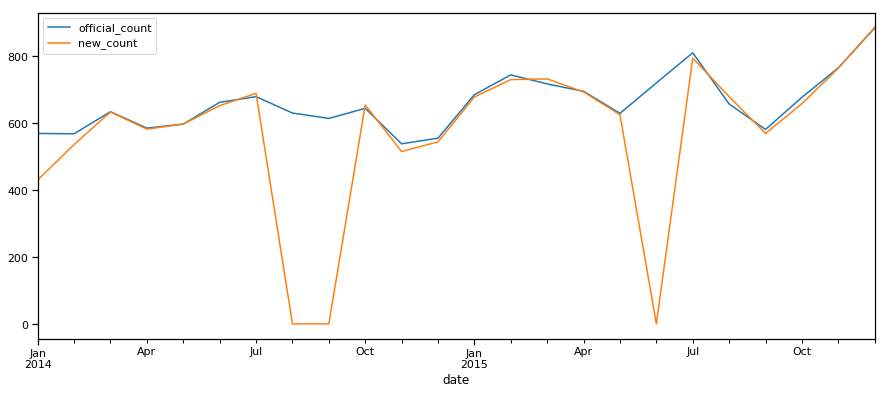

In [5]:

j.loc['2014':'2015'].plot(figsize=(15,6))

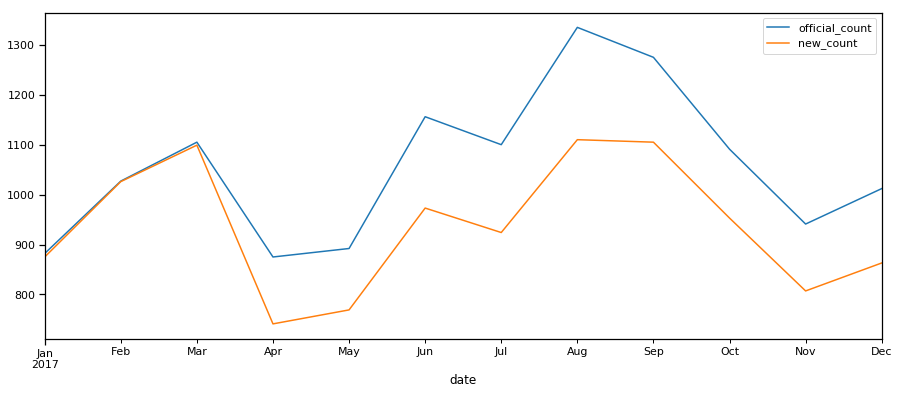

In [6]:
j.loc['2017'].plot(figsize=(15,6))

Text(0.5, 1.0, 'Sleeper Count Per Month For Offical Data vs This Dataset')

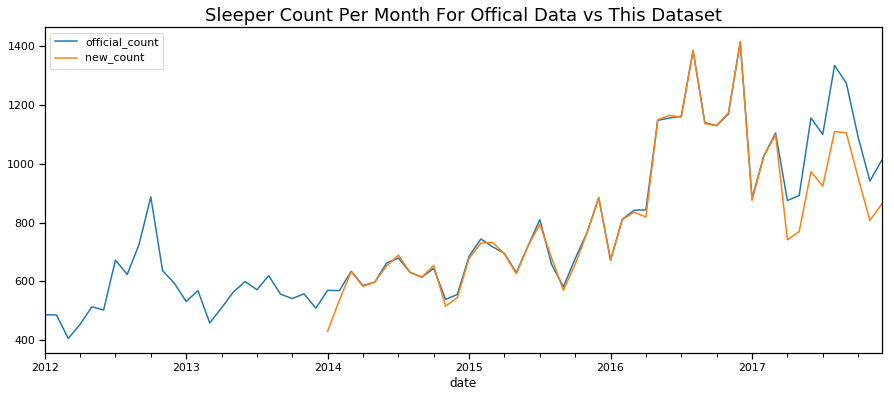

In [7]:
hc = pkg.resource('imputed_counts').geoframe()
hc['new_count'] = 1
t = hc.set_index('date').groupby(pd.Grouper(freq="MS")).new_count.count().to_frame()
mt = pkg.resource('monthly_totals').dataframe().set_index('date').groupby(pd.Grouper(freq="MS")).sum().rename(columns={'count':'official_count'})

j = mt.join(t)
ax = j.plot(figsize=(15,6))
ax.set_title('Sleeper Count Per Month For Offical Data vs This Dataset', fontsize=18)
